# Inference Test Code for CLIP

In [170]:
from transformers import DistilBertTokenizer
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append('../')
import importlib
import factory
importlib.reload(factory)
from model import mae_clip
importlib.reload(mae_clip)
from model import clip
importlib.reload(clip)
from model import mae
importlib.reload(mae)
from factory import OriginalViTCLIPFactory, MAECLIPFactory
from model.mae_clip import MAECLIP

import misc.transforms
importlib.reload(misc.transforms)
from misc.transforms import get_original_vit_image_encoder_transforms

### model load

In [171]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [172]:
class CFG:
    image_encoder_name = "vit_base_patch16_224.augreg2_in21k_ft_in1k"
    image_encoder_pretrained = False
    image_encoder_trainable = True

    text_encoder_name = "distilbert-base-uncased"
    text_encoder_pretrained = True
    text_encoder_trainable = False

    temperature = 1.0

    image_size = 224
    patch_size = 14
    image_embedding = 512
    text_embedding = 768
    projection_dim = 256
    dropout = 0.1

    mask_ratio = 0.75
    alpha = 0

In [173]:
cfg = CFG()

# model_path = "/data/yuto/clip/OpenAI-CLIP/output/resnet_text_encoder_fix/checkpoints/checkpoint_9.pth"
# model_path = "/data/yuto/clip/OpenAI-CLIP/output/resnet_text_encoder_fix/checkpoints/checkpoint_3.pth"
# model_path = "/home/ykojima/Desktop/clip/mae_clip/output/vit_text_encoder_fix/checkpoints/checkpoint_5.pth"
# model_path = "/home/ykojima/Desktop/clip/mae_clip/output/vit_scratch_text_encoder_fix/checkpoints/checkpoint_1.pth"
# model_path = "/home/ykojima/Desktop/clip/mae_clip/20240116_original_vit_scratch_training/checkpoint_21.pth"
# model_path = "/home/ykojima/Desktop/clip/mae_clip/20240117_mae_clip_joint_scratch_training/checkpoint_20.pth"
model_path = "/home/ykojima/Desktop/clip/mae_clip/20240118_mae_clip_joint_scratch_training_alpha=0/checkpoint_8.pth"

factory = MAECLIPFactory(cfg)
model = factory.create().to("cuda")
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model = model.clip
model.eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 23.64 GiB of which 17.25 MiB is free. Process 227808 has 1.38 GiB memory in use. Including non-PyTorch memory, this process has 6.23 GiB memory in use. Process 322532 has 5.02 GiB memory in use. Process 327026 has 1.39 GiB memory in use. Process 341276 has 7.15 GiB memory in use. Process 357389 has 752.00 MiB memory in use. Process 357292 has 1.56 GiB memory in use. Of the allocated memory 5.51 GiB is allocated by PyTorch, and 270.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [159]:
text = tokenizer(["a diagram", "a dog", "a cat", "noodle"])
batch = {key: torch.tensor(values).to("cuda") for key, values in text.items()}
text_features = model.text_encode(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

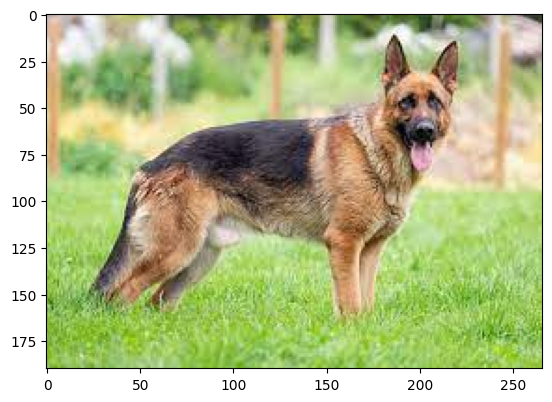

In [160]:
transforms = get_original_vit_image_encoder_transforms('valid')

filename = "../inputs/dog.jpeg"
image = Image.open(filename)
plt.imshow(image)

image = transforms(image).unsqueeze(0)
image_features = model.image_encode(image.to("cuda"))

### Matching between image embeddings and text embedings

In [161]:
# L2ノルムで normalization
# dim=-1 means normalization along with last dimention that is embedding
image_features_n = F.normalize(image_features, dim=-1)
text_features_n = F.normalize(text_features, dim=-1) # shape: (n, 256)
# print(sum(text_embeddings_n[0]*text_embeddings_n[0]) is 1

similarity = image_features @ text_features.T
print(similarity)

# Why do you multiply by 100?
# why is 100 bultiplyed
text_probs = (image_features @ text_features.T).softmax(dim=-1)

print("Label probs:", text_probs)

tensor([[11.8338, 18.3755, 15.9520, 13.4148]], device='cuda:0',
       grad_fn=<MmBackward0>)
Label probs: tensor([[0.0013, 0.9115, 0.0808, 0.0064]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
